# **AstrID:**  *predictions*

### Importing Necessary Libraries and Modules

In this section, we import the necessary libraries and modules required for validating our model. These include:

- **TensorFlow and Keras**: For loading and using the trained neural network.
- **NumPy**: For numerical operations and handling arrays.
- **Matplotlib**: For plotting and visualizing data.
- **Astropy**: For handling FITS files and WCS data.
- **Custom Functions**: 
    - [`dataGathering`](dataGathering.py): to handle data extraction.
    - [`imageProcessing`](imageProcessing.py): for image modification to fit model requirements.

The comments in the code provide additional details about each import.

In [ ]:
import os
from keras.models import load_model
import tensorflow as tf
from keras import backend as K

# Import custom functions to import the dataset
from scripts.dataGathering import importDataset

# Import custom function to preprocess Image and Pixel Mask arrays
from scripts.imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage
from scripts.imageProcessing import showPredictionComparison, savePredictionComparison, showPredictionOverlay, savePredictionOverlay

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

### Loading the Dataset

We load the dataset using the `importDataset` function from the `dataGathering` module. This function extracts the images, masks, star data, WCS data, and FITS file names from the specified dataset path.

In [ ]:
# Create images and masks arrays lists
images = []
masks = []

# Create a list of all the wcs data in the dataset folder
wcs_data = []

# Create an array to store the star data inside each fits file
stars_in_image = []

# Create a list of all the fits files in the dataset folder
fits_files = []

# Define the path to the dataset
dataset_path = 'data/fits/'

# Define the name of the dataset ('data' for training, 'validate' for validation)
dataset_name = 'validate'

# Import the dataset
images, masks, stars_in_image, wcs_data, fits_files = importDataset(dataset_path=dataset_path, dataset_name=dataset_name)

### Preparing Images and Masks for the Model

To ensure our images and masks are in the correct format for validation, we need to perform some transformations. Our model expects the images to have three channels, similar to standard RGB images, and the masks to have a single channel. Here’s how we achieve this:

**Convert Images to 3-Channel Format:** Our images are currently in the shape `(512, 512)`, but the model requires them to be in the shape `(512, 512, 3)`. To convert the single-channel images into 3-channel images, we stack the images along the last axis three times. This transformation is necessary because the model typically expects 3-channel input images.

**Convert Masks to Single-Channel Format:** For the masks, the model expects them to be in the shape `(512, 512, 1)`. We expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

**Convert to NumPy Arrays:** Both the images and masks need to be converted to NumPy arrays, as this is the desired format for the validation model. This conversion ensures that the data is in the correct format for validation.

Below, we perform these conversions to ensure the data is in the correct format for validation.

In [ ]:
test_images = stackImages(images)
test_masks = stackMasks(masks)

### Normalizing the Images

To standardize the pixel values in our images, we need to normalize them to a common range. We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [ ]:
# test_images = normalizeImages(test_images)

### Choose the Correct Model

We display models in the saved models directory. The most recent model is chosen to load, if you train and save a new model ensure it is listed as the `model_choice`.

In [ ]:
# Display all the models in the models folder
saved_models_path = 'models/'
model_files = os.listdir(saved_models_path)
model_files = [file for file in model_files if file.endswith('.keras')]
model_files = sorted(model_files)
model_files


In [ ]:
# Pick the most recent model
model_choice = model_files[-1]

In [ ]:
#List your model choice to load for verification
model_choice

### Loading the Trained Model

We load the trained U-Net model from the saved models directory. The model is used to make predictions on the test dataset.

In [10]:
# Load the saved model
model = load_model(saved_models_path + model_choice)

### Visualizing Results

We visualize the results by plotting the original images, ground truth masks, and predicted masks. This helps us understand how well the model is performing.

2024-11-30 22:15:01.274835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 1s 1s/step


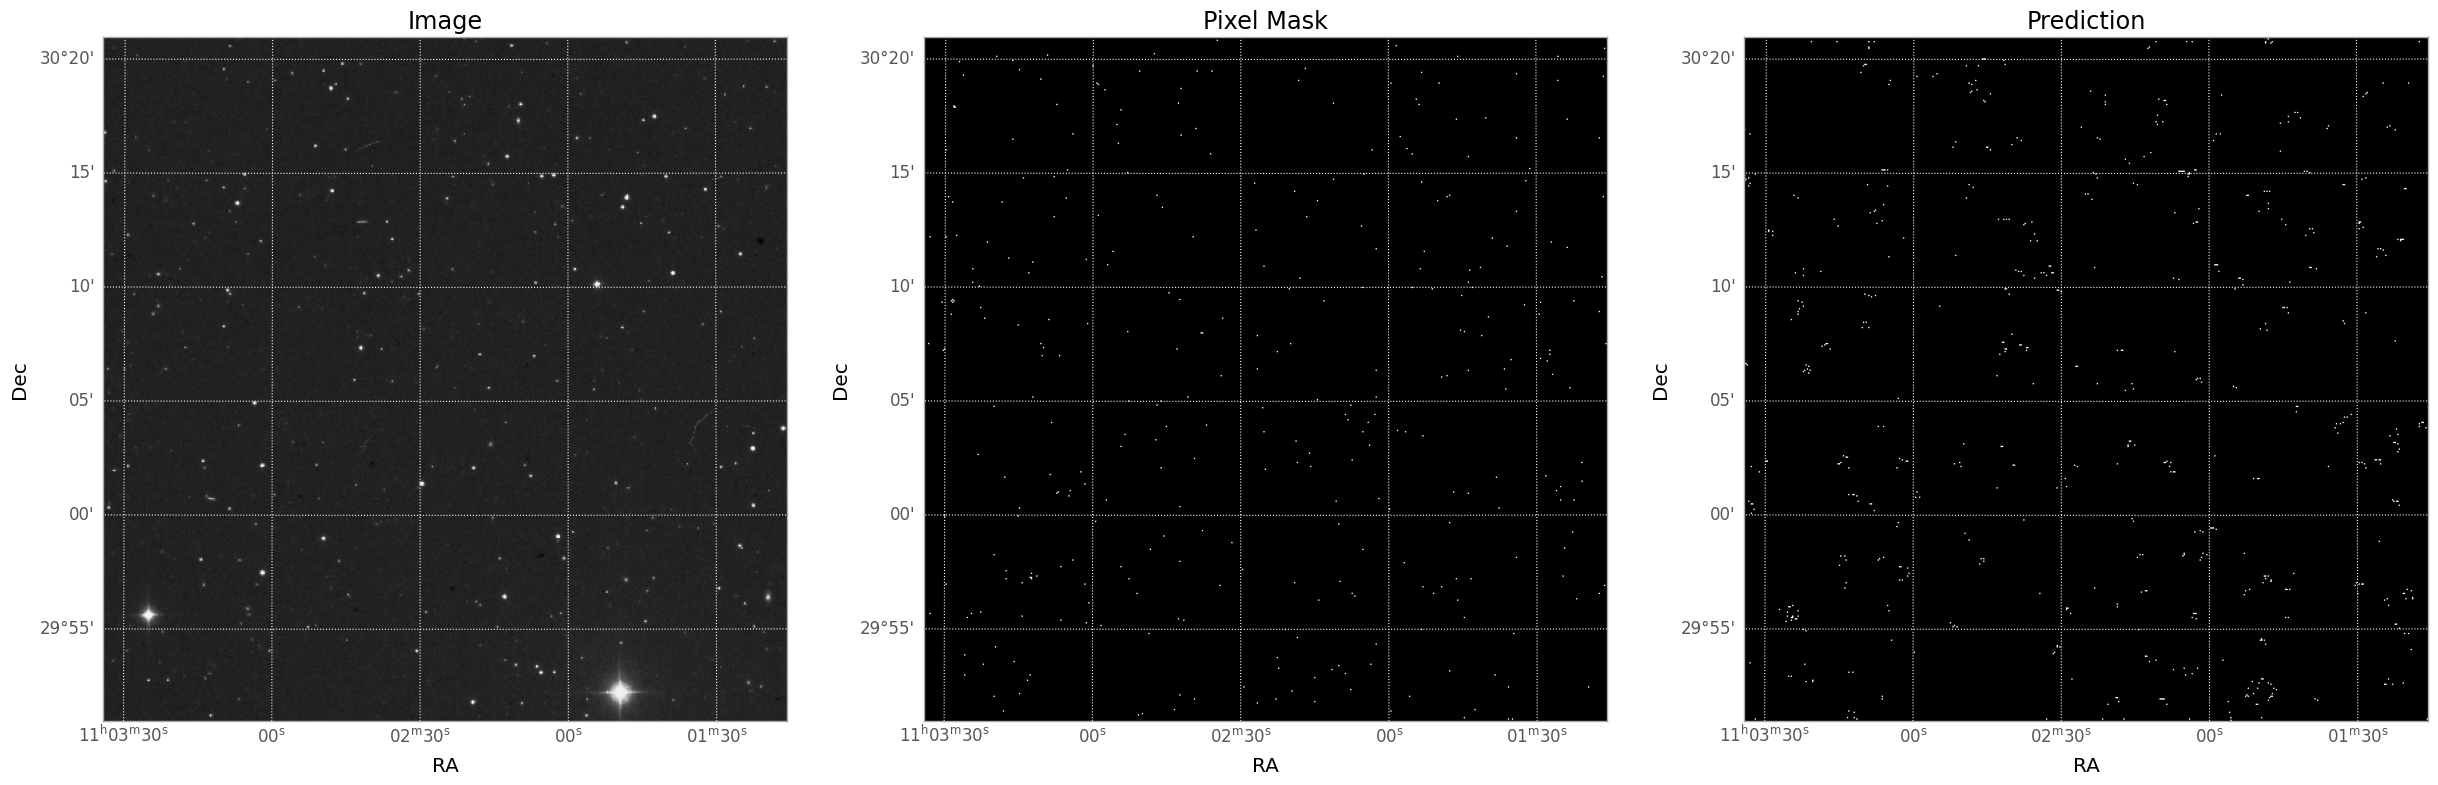

1/1 [==============================] - 0s 24ms/step
626
Drawing
Drawing


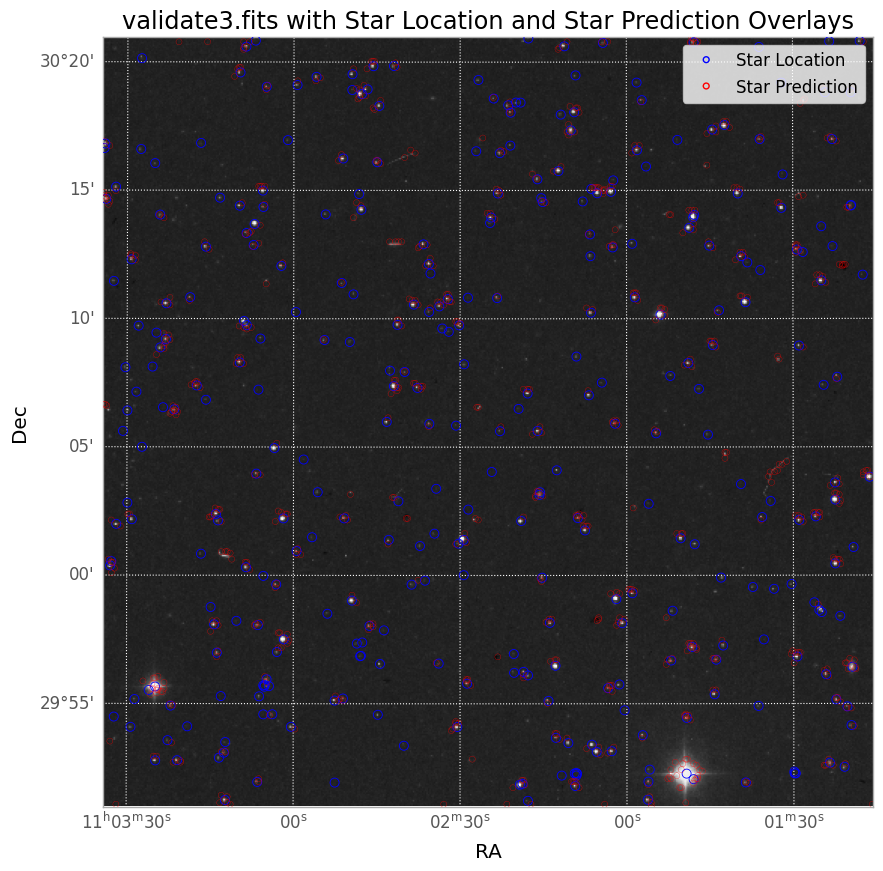

1/1 [==============================] - 0s 19ms/step


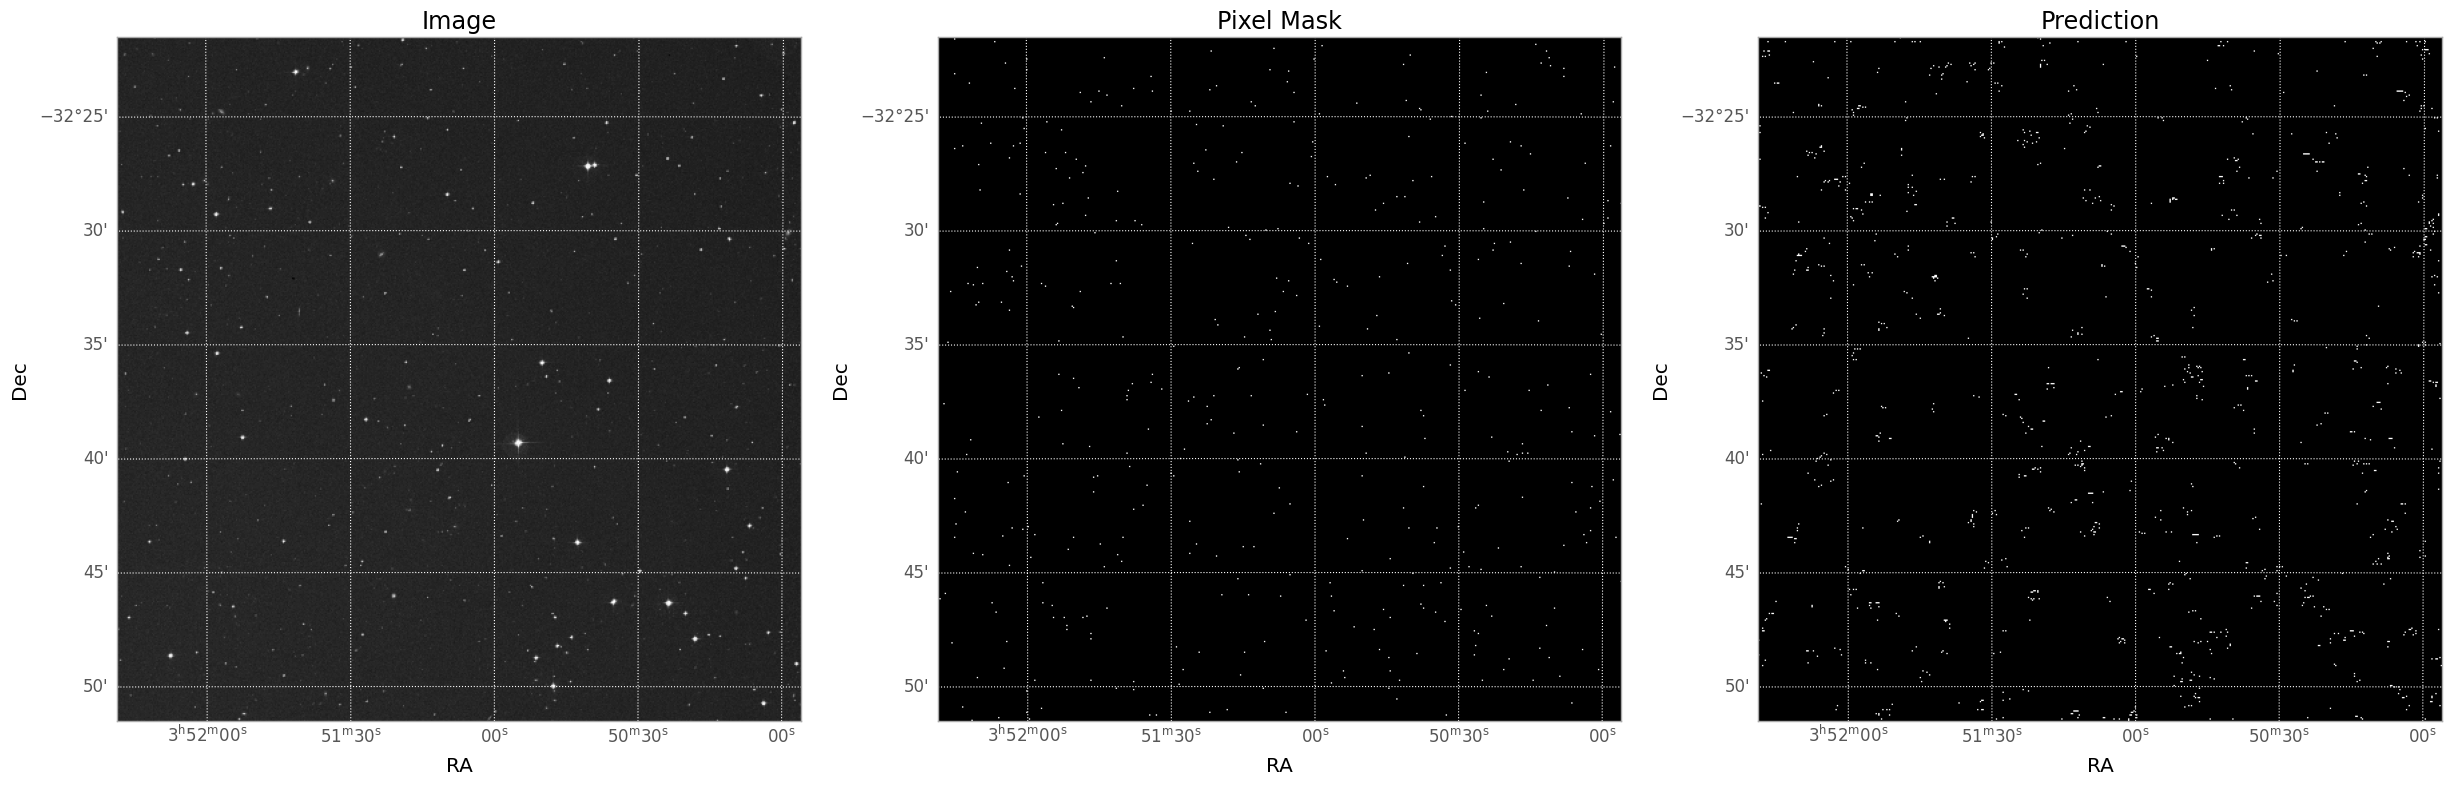

1/1 [==============================] - 0s 19ms/step
1194
Drawing
Drawing


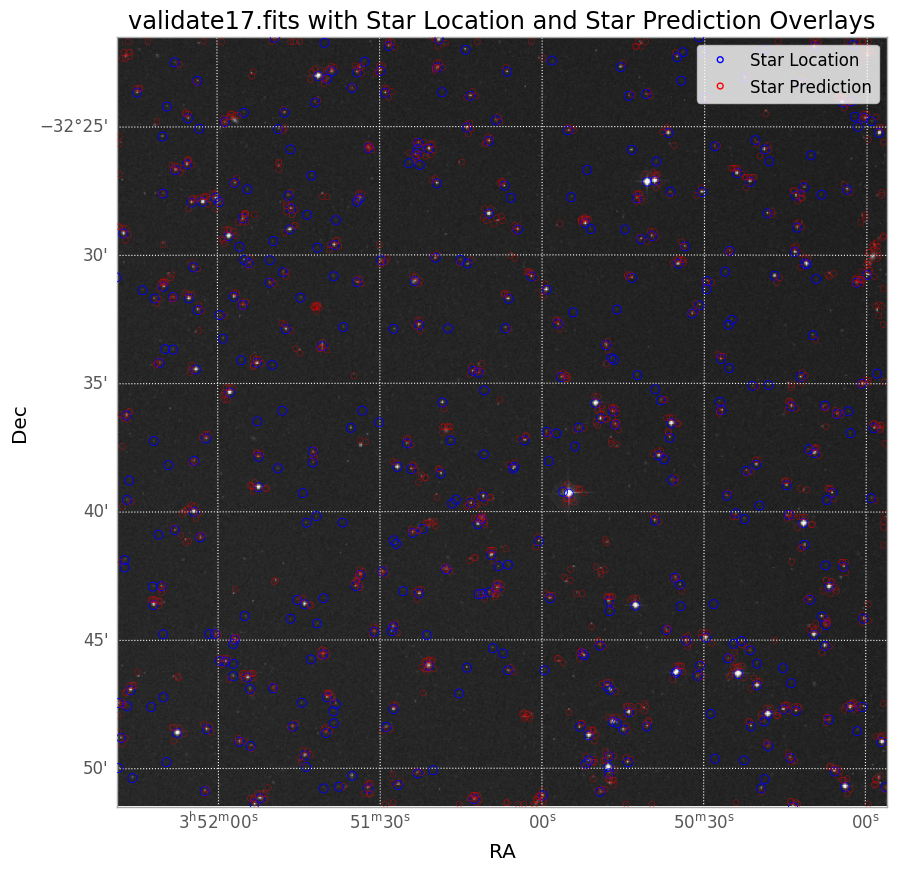

1/1 [==============================] - 0s 20ms/step


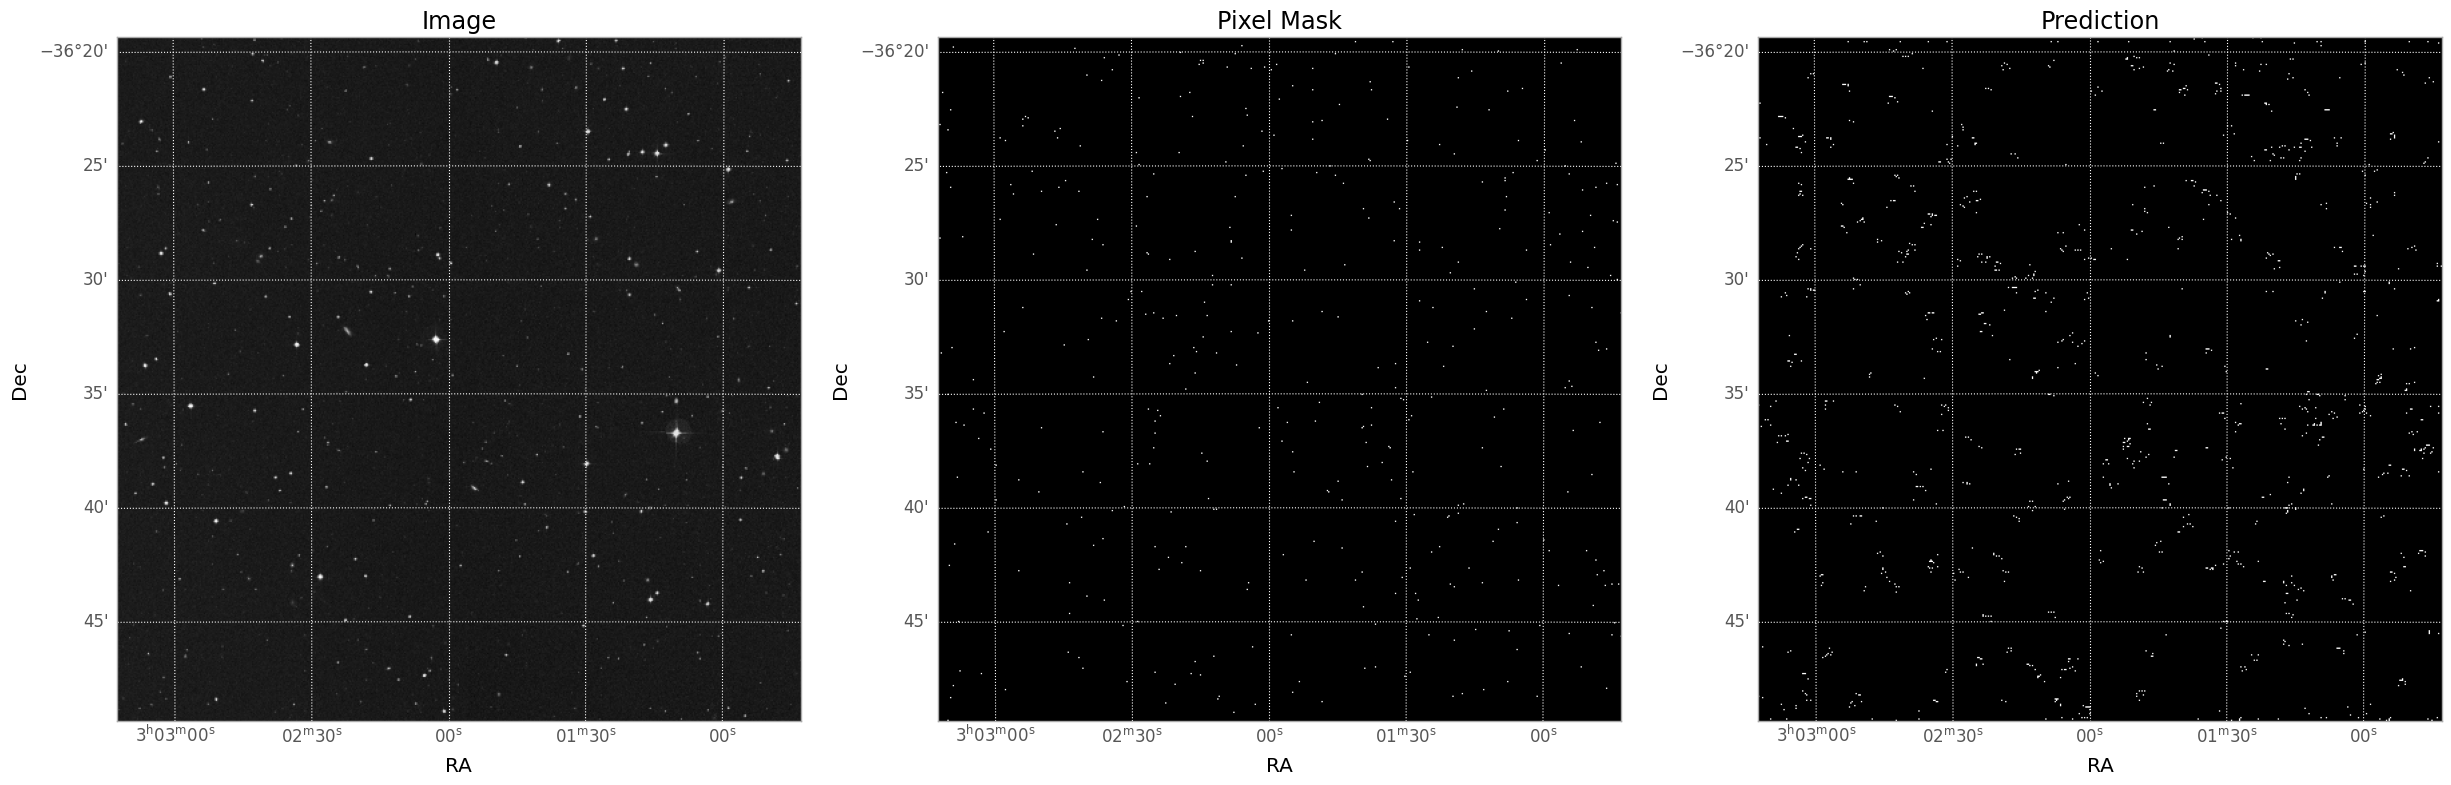

1/1 [==============================] - 0s 21ms/step
1201
Drawing
Drawing


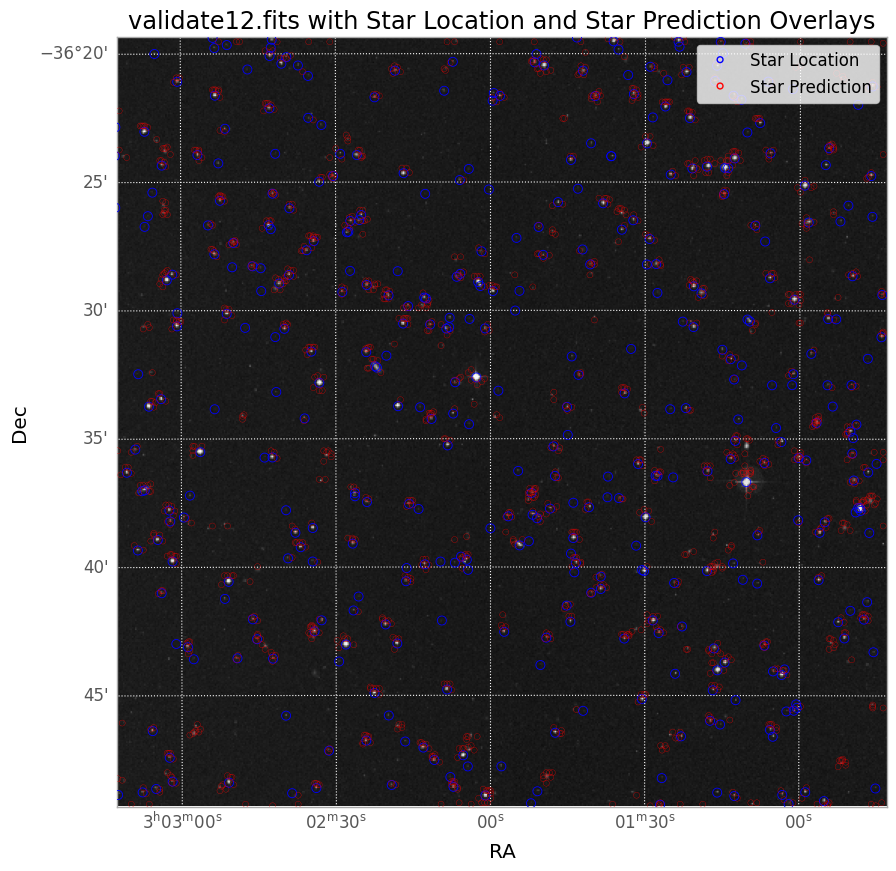

1/1 [==============================] - 0s 20ms/step


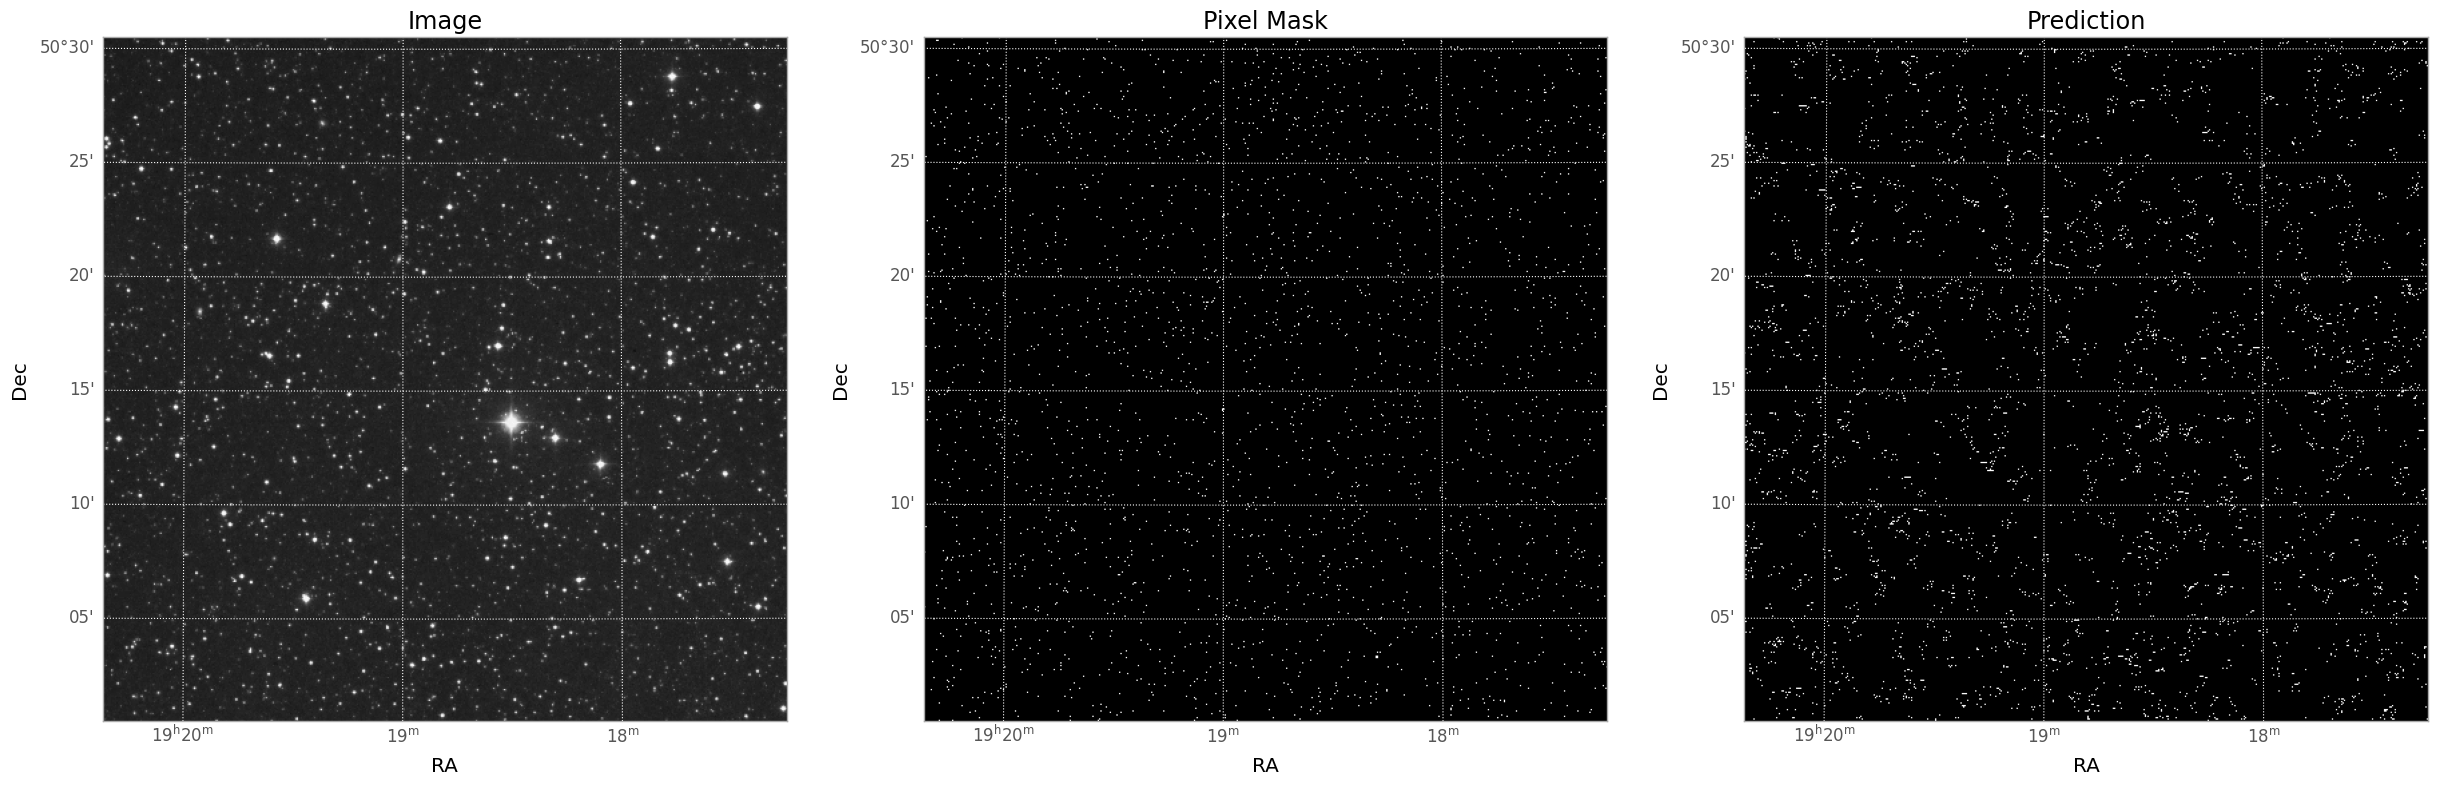

1/1 [==============================] - 0s 19ms/step
4403
Drawing
Drawing


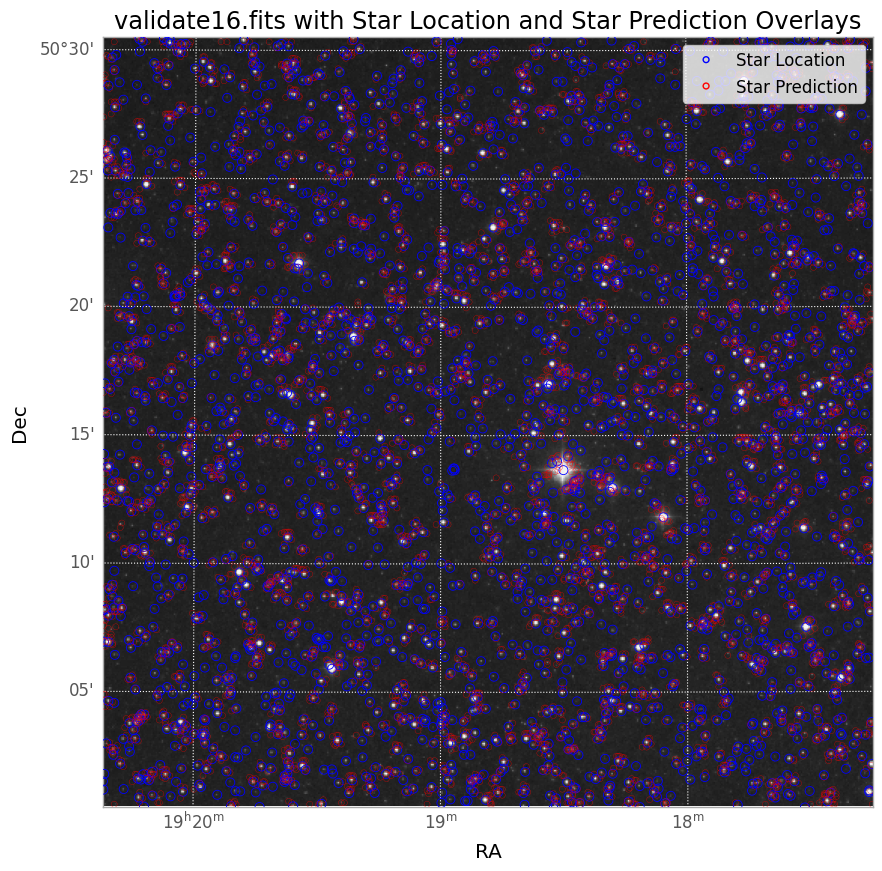

In [11]:
# Plot the results from the model
for i in range(4):
    showPredictionComparison(images, test_masks, test_images, model, wcs_data, selection = i, threshold=0.5)
    showPredictionOverlay(images, test_masks, test_images, model, stars_in_image, wcs_data, fits_files, selection=i, threshold=0.5)

### Evaluating the Model

We evaluate the model's performance on the test dataset. We calculate the loss and accuracy metrics to assess the model's effectiveness.

In [12]:
# Reduce batch size for evaluation
batch_size = 4

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_masks, batch_size=batch_size, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

5/5 [==============================] - 2s 70ms/step - loss: 0.0723 - accuracy: 0.9865
Test Loss: 0.07227408140897751
Test Accuracy: 0.9865432977676392


### Making Predictions

We use the trained model to make predictions on the test dataset. The predictions are compared with the ground truth masks to evaluate the model's performance.

In [13]:
predictions = model.predict(test_images, batch_size=batch_size, verbose=1)

5/5 [==============================] - 0s 68ms/step


### Saving Results

We save the results, including the original images, ground truth masks, and predicted masks, to the results directory. This allows us to review and analyze the model's performance later.

In [ ]:
# Iterate over the test set and save the image with overlayed mask and prediction to a file
for i in range(len(test_images)):
    savePredictionComparison(images, test_masks, test_images, model, wcs_data, fits_files, selection = i, threshold=0.5)
    savePredictionOverlay(images, test_masks, test_images, model, stars_in_image, wcs_data, fits_files, selection=i, threshold=0.5)